# **Higgs boson detection**


# 0 - Data Vizualisation and Preprocessing

### 0 - Defining the metric

In [61]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_ams_with_labels(true_labels, predicted_labels, weights, br=10):
    """
    Compute the Approximate Median Significance (AMS) directly from labels and weights.
    
    Parameters:
    - true_labels: numpy array, true test labels (1 for signal 's', 0 for background 'b')
    - predicted_labels: numpy array, predicted test labels (1 for signal 's', 0 for background 'b')
    - weights: numpy array, event weights
    - br: float, regularization term (default=10)
    
    Returns:
    - AMS score
    """
    # Mask for signal (true signal and predicted as signal)
    signal_mask = (true_labels == 1) & (predicted_labels == 1)
    s = np.sum(weights[signal_mask])  # Sum of weights for true positives (signal)

    # Mask for background (true background and predicted as signal)
    background_mask = (true_labels == 0) & (predicted_labels == 1)
    b = np.sum(weights[background_mask])  # Sum of weights for false positives (background)

    # Compute AMS
    if b + br == 0:
        return 0  # Avoid division by zero
    return np.sqrt(2 * ((s + b + br) * np.log(1 + s / (b + br)) - s))


### 1- Importation des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import csv
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 2- Lecture des fichiers CSV
Jeu de données disponible dans http://opendata.cern.ch/record/328


First, understanding the dataset, its features, and what we aim to predict is crucial to ensure that important data is preserved during preprocessing.

This involves particle physics simulations where proton-proton collisions are modeled in space, followed by the simulation of their dynamics until they reach a virtual detector. Statistical thermal phenomena are also introduced, which could be biased as they are likely induced using MCMC.

These collisions notably produce Higgs bosons, which can be inferred in the detector by the presence of measurements (with a fixed mass of 125 GeV). Of course, other particles may also be detected. In this simulation, the number of other detected particles is limited to three: 
- A Z boson (with a mass of 91.2 GeV) decaying into two taus.
- A pair of two top quarks decaying into leptonic and hadronic taus.
- The decay of a W boson, which might lead the detector to mistakenly register the simultaneous presence of an electron and a hadronic tau (an artifact of measurement error).

## **Dataset Variables and Descriptions**

This table provides detailed descriptions of the variables in the dataset.

| **Variable**               | **Description**                                                                                                                                                                                                                           |
|----------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **EventId**                | A unique integer identifier for the event.                                                                                                                                                                                              |
| **DER_mass_MMC**           | The estimated mass \(m_H\) of the Higgs boson candidate, obtained through a probabilistic phase space integration.                                                                                                                        |
| **DER_mass_transverse_met_lep** | The transverse mass between the missing transverse energy and the lepton.                                                                                                                                                         |
| **DER_mass_vis**           | The invariant mass of the hadronic tau and the lepton.                                                                                                                                                                                   |
| **DER_pt_h**               | The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton, and the missing transverse energy vector.                                                                                                      |
| **DER_deltaeta_jet_jet**   | The absolute value of the pseudorapidity separation between the two jets (undefined if \( \text{PRI\_jet\_num} \leq 1 \)).                                                                                                               |
| **DER_mass_jet_jet**       | The invariant mass of the two jets (undefined if \( \text{PRI\_jet\_num} \leq 1 \)).                                                                                                                                                     |
| **DER_prodeta_jet_jet**    | The product of the pseudorapidities of the two jets (undefined if \( \text{PRI\_jet\_num} \leq 1 \)).                                                                                                                                     |
| **DER_deltar_tau_lep**     | The \( \Delta R \) separation between the hadronic tau and the lepton.                                                                                                                                                                   |
| **DER_pt_tot**             | The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if \( \text{PRI\_jet\_num} \geq 1 \)), and the subleading jet (if \( \text{PRI\_jet\_num} = 2 \)).                                |
| **DER_sum_pt**             | The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if \( \text{PRI\_jet\_num} \geq 1 \)), the subleading jet (if \( \text{PRI\_jet\_num} = 2 \)), and any additional jets (if \( \text{PRI\_jet\_num} = 3 \)).                     |
| **DER_pt_ratio_lep_tau**   | The ratio of the transverse momenta of the lepton and the hadronic tau.                                                                                                                                                                  |
| **DER_met_phi_centrality** | The centrality of the azimuthal angle of the missing transverse energy vector relative to the hadronic tau and the lepton.                                                                                                               |
| **DER_lep_eta_centrality** | The centrality of the pseudorapidity of the lepton relative to the two jets (undefined if \( \text{PRI\_jet\_num} \leq 1 \)).                                                                                                             |
| **PRI_tau_pt**             | The transverse momentum \( \sqrt{p_x^2 + p_y^2} \) of the hadronic tau.                                                                                                                                                                 |
| **PRI_tau_eta**            | The pseudorapidity \( \eta \) of the hadronic tau.                                                                                                                                                                                       |
| **PRI_tau_phi**            | The azimuthal angle \( \phi \) of the hadronic tau.                                                                                                                                                                                      |
| **PRI_lep_pt**             | The transverse momentum \( \sqrt{p_x^2 + p_y^2} \) of the lepton (electron or muon).                                                                                                                                                     |
| **PRI_lep_eta**            | The pseudorapidity \( \eta \) of the lepton.                                                                                                                                                                                             |
| **PRI_lep_phi**            | The azimuthal angle \( \phi \) of the lepton.                                                                                                                                                                                            |
| **PRI_met**                | The missing transverse energy \( \vec{E}_T^{\text{miss}} \).                                                                                                                                                                            |
| **PRI_met_phi**            | The azimuthal angle \( \phi \) of the missing transverse energy.                                                                                                                                                                         |
| **PRI_met_sumet**          | The total transverse energy in the detector.                                                                                                                                                                                             |
| **PRI_jet_num**            | The number of jets (integer with values \( 0, 1, 2, \) or \( 3 \); possible larger values are capped at \( 3 \)).                                                                                                                         |
| **PRI_jet_leading_pt**     | The transverse momentum \( \sqrt{p_x^2 + p_y^2} \) of the leading jet, the jet with the largest transverse momentum (undefined if \( \text{PRI\_jet\_num} = 0 \)).                                                                         |
| **PRI_jet_leading_eta**    | The pseudorapidity \( \eta \) of the leading jet (undefined if \( \text{PRI\_jet\_num} = 0 \)).                                                                                                                                           |
| **PRI_jet_leading_phi**    | The azimuthal angle \( \phi \) of the leading jet (undefined if \( \text{PRI\_jet\_num} = 0 \)).                                                                                                                                          |
| **PRI_jet_subleading_pt**  | The transverse momentum \( \sqrt{p_x^2 + p_y^2} \) of the subleading jet, the jet with the second-largest transverse momentum (undefined if \( \text{PRI\_jet\_num} \leq 1 \)).                                                           |
| **PRI_jet_subleading_eta** | The pseudorapidity \( \eta \) of the subleading jet (undefined if \( \text{PRI\_jet\_num} \leq 1 \)).                                                                                                                                     |
| **PRI_jet_subleading_phi** | The azimuthal angle \( \phi \) of the subleading jet (undefined if \( \text{PRI\_jet\_num} \leq 1 \)).                                                                                                                                    |
| **PRI_jet_all_pt**         | The scalar sum of the transverse momentum of all jets in the event.                                                                                                                                                                      |
| **Weight**                 | The event weight \( w_i \).                                                                                                                                                                                                              |
| **Label**                  | The event label (string) \( y_i \in \{s, b\} \) (\( s \) for signal, \( b \) for background).                                                                                                                                             |
| **KaggleSet**              | String specifying which Kaggle set the event belongs to: “t” (training), “b” (public leaderboard), “v” (private leaderboard), or “u” (unused).                                                                                          |
| **KaggleWeight**           | Weight normalized within each Kaggle dataset.                                                                                                                                                                                            |


On comprend assez vite que certaine valeurs de PRI jet peuvent etre non défini, car elle depende des conditions de l'espérience, il n'est pas nécéssaire d'abandonner ces features 

In [30]:
dataFilename = 'data/atlas-higgs.csv'
data = pd.read_csv(dataFilename)
print("data shape : ",data.shape)
data.head()

data shape :  (818238, 35)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818238 entries, 0 to 818237
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      818238 non-null  int64  
 1   DER_mass_MMC                 818238 non-null  float64
 2   DER_mass_transverse_met_lep  818238 non-null  float64
 3   DER_mass_vis                 818238 non-null  float64
 4   DER_pt_h                     818238 non-null  float64
 5   DER_deltaeta_jet_jet         818238 non-null  float64
 6   DER_mass_jet_jet             818238 non-null  float64
 7   DER_prodeta_jet_jet          818238 non-null  float64
 8   DER_deltar_tau_lep           818238 non-null  float64
 9   DER_pt_tot                   818238 non-null  float64
 10  DER_sum_pt                   818238 non-null  float64
 11  DER_pt_ratio_lep_tau         818238 non-null  float64
 12  DER_met_phi_centrality       818238 non-null  float64
 13 

In [4]:
data.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,KaggleWeight
count,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,...,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000
mean,509118.500000,-48.819019,49.252714,81.140561,57.849524,-707.740880,-600.191191,-708.681306,2.373871,18.969617,...,0.979923,-348.757840,-399.693294,-399.703858,-691.626111,-708.442206,-708.443312,73.205594,0.503144,2.012577
std,236205.109118,406.118397,35.378609,40.582708,63.411938,454.793899,658.724040,453.328599,0.780875,21.918491,...,0.978793,533.097006,489.428560,489.420013,480.274744,453.699150,453.697158,98.331754,0.572200,5.439641
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.000461,0.000839
25%,304559.250000,78.166000,19.304000,59.414000,14.164250,-999.000000,-999.000000,-999.000000,1.814000,2.839000,...,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.005721,0.010415
50%,509118.500000,105.061000,46.484000,73.744000,38.470000,-999.000000,-999.000000,-999.000000,2.492000,12.383000,...,1.000000,38.965000,-1.865000,-2.105000,-999.000000,-999.000000,-999.000000,40.506000,0.357223,0.806562
75%,713677.750000,130.730000,73.620000,92.188000,79.226750,0.499000,84.031750,-4.548000,2.962000,27.634000,...,2.000000,75.470750,0.432000,0.489000,33.800000,-2.436000,-2.265000,110.387000,0.733462,2.360271
max,918237.000000,1949.261000,968.669000,1349.351000,2834.999000,8.724000,4974.979000,17.650000,5.751000,2834.999000,...,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000,2.386316,106.908407


### 3- Remove Redundant Columns
Use the `del` function to remove the columns `'EventId'`, `'Weight'`, `'KaggleSet'`, and `'KaggleWeight'`.  
Next, transform the `'label'` column into binary values (0/1).


In [31]:
del(data['EventId'])
del(data['KaggleSet'])
del(data['KaggleWeight'])

In [32]:
data['Label'] = data['Label'].map({'s':1, 'b':0})

### 4- Selecting an subsample of the data
We randomly sample to obtain a representative dataset that is quicker to preprocess.

In [33]:
data = data.sample(frac= .1)

### 5- Handle Missing Data and Outliers

Missing data in this file is indicated by -999. To replace them, the `SimpleImputer` class should be used.

In [8]:
(data == -999.0).sum(axis =0)

DER_mass_MMC                   12576
DER_mass_transverse_met_lep        0
DER_mass_vis                       0
DER_pt_h                           0
DER_deltaeta_jet_jet           58042
DER_mass_jet_jet               58042
DER_prodeta_jet_jet            58042
DER_deltar_tau_lep                 0
DER_pt_tot                         0
DER_sum_pt                         0
DER_pt_ratio_lep_tau               0
DER_met_phi_centrality             0
DER_lep_eta_centrality         58042
PRI_tau_pt                         0
PRI_tau_eta                        0
PRI_tau_phi                        0
PRI_lep_pt                         0
PRI_lep_eta                        0
PRI_lep_phi                        0
PRI_met                            0
PRI_met_phi                        0
PRI_met_sumet                      0
PRI_jet_num                        0
PRI_jet_leading_pt             32852
PRI_jet_leading_eta            32852
PRI_jet_leading_phi            32852
PRI_jet_subleading_pt          58042
P

In [34]:
data = data.replace(-999.0, np.nan)

In [48]:
#Traitement des données manquantes désignées par -999
print("Percentage of N/A values : \n",data[data.columns[(data.isna().sum() != 0).values]].isna().sum()/ len(data))
print("Remaining colomns have not N/A values")

Percentage of N/A values : 
 DER_mass_MMC              0.151435
DER_deltaeta_jet_jet      0.708582
DER_mass_jet_jet          0.708582
DER_prodeta_jet_jet       0.708582
DER_lep_eta_centrality    0.708582
PRI_jet_leading_pt        0.398832
PRI_jet_leading_eta       0.398832
PRI_jet_leading_phi       0.398832
PRI_jet_subleading_pt     0.708582
PRI_jet_subleading_eta    0.708582
PRI_jet_subleading_phi    0.708582
dtype: float64
Remaining colomns have not N/A values


In [49]:
data_fill_median = data.fillna(data.median())

data_drop_na = data.dropna()

### Outliers

Check if the dataset contains outliers by displaying boxplots for all columns.

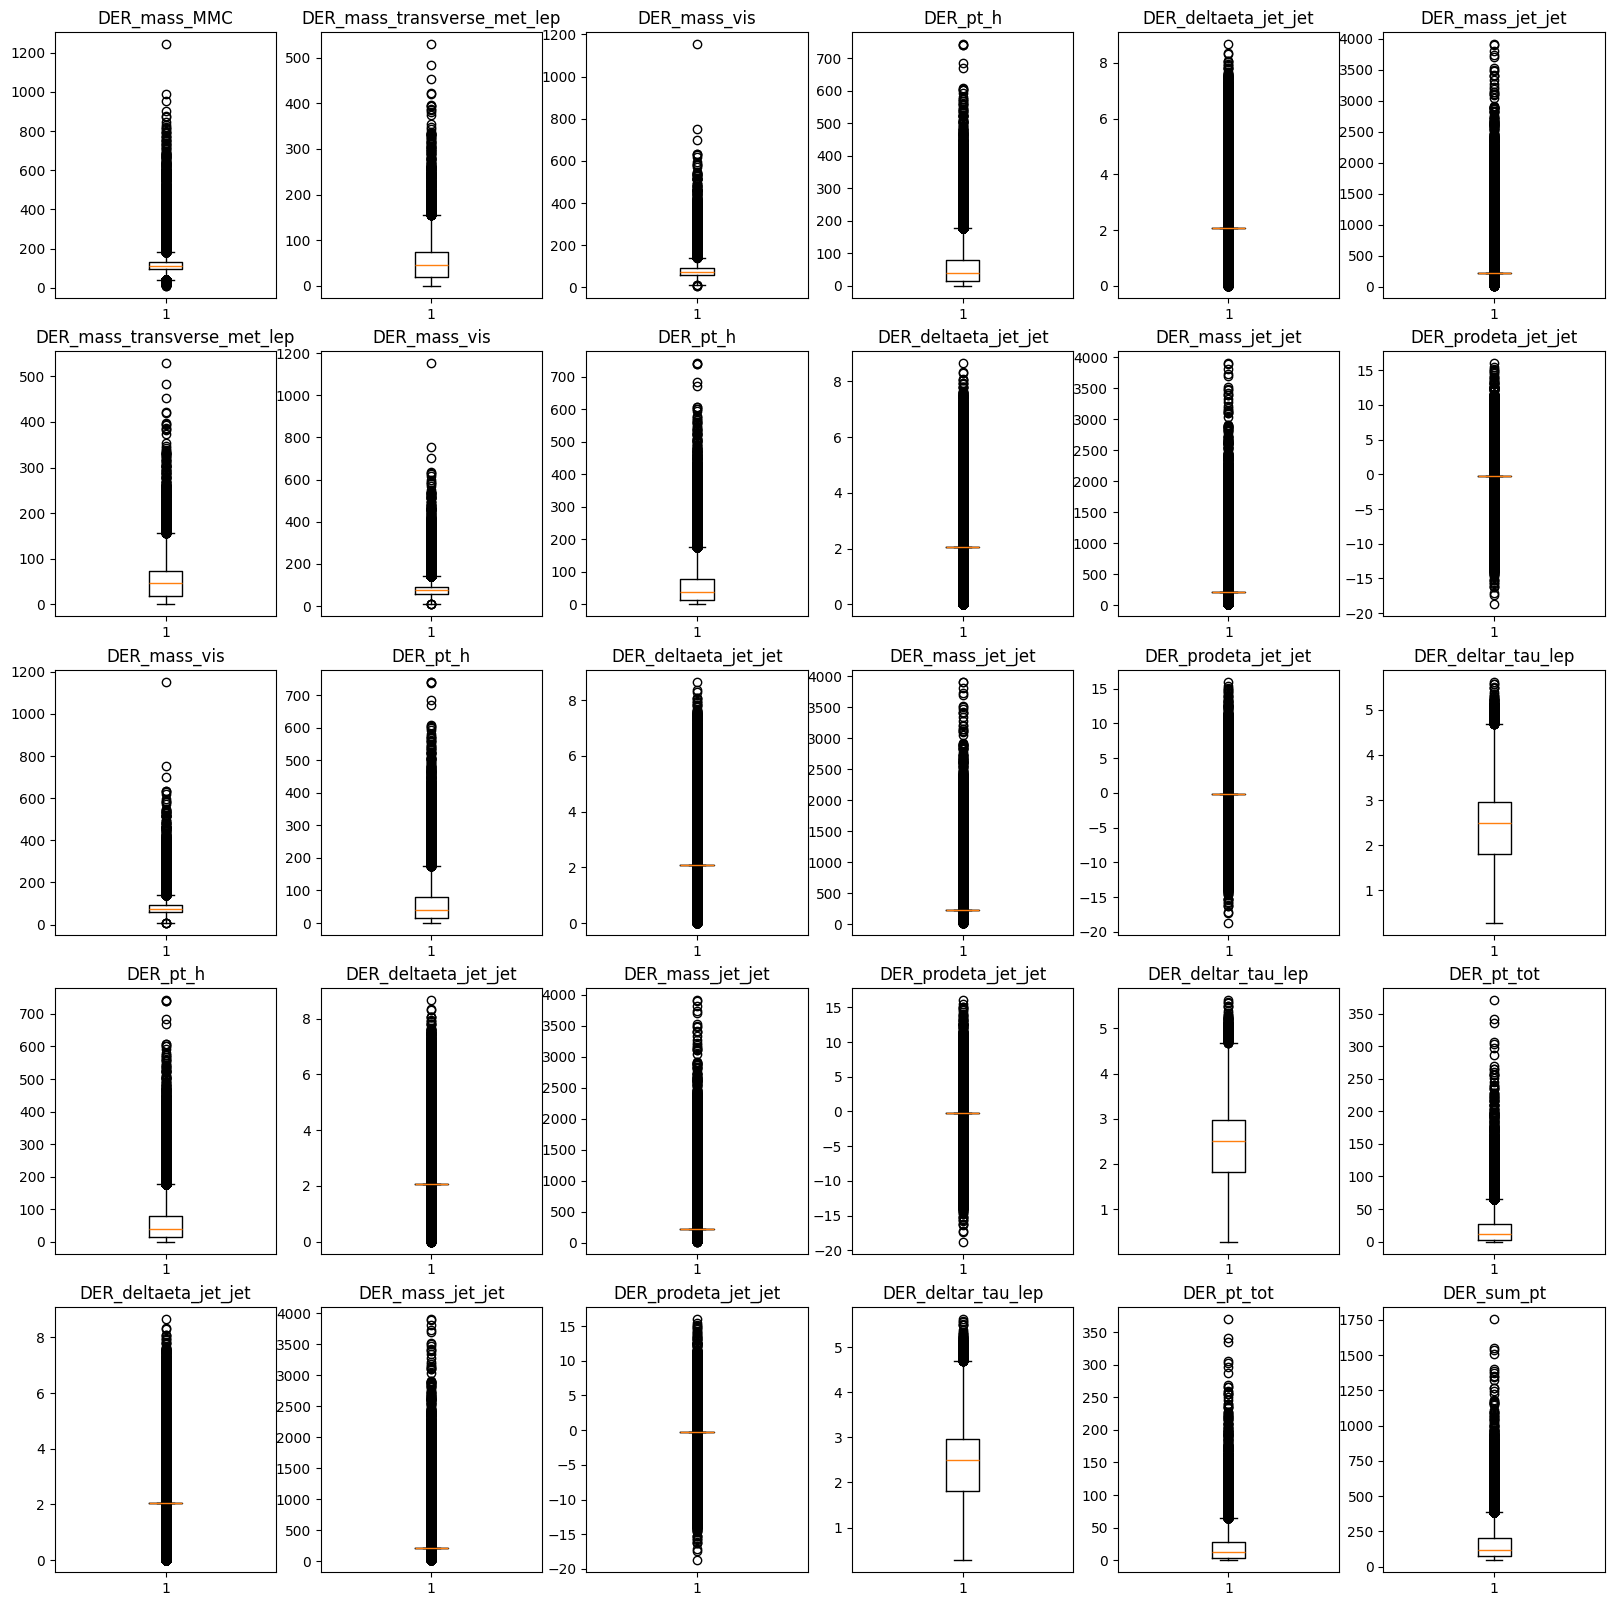

In [51]:
data = data_fill_median

fig, axs = plt.subplots(int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])+ 1), figsize = (20,20))
for i in range(int(np.sqrt(data.shape[1]))):
    for j in range(int(np.sqrt(data.shape[1]) + 1)) : 
        axs[i,j].boxplot(x=data.columns[i+j], data=data)
        axs[i,j].set_title(data.columns[i+j])
plt.show()

### Importance of One-Hot Encoding PRI_jet_num

This step is crucial because, depending on the value of PRI_jet_num, a significant portion of the data contains null values, which have been replaced with their median value. It is important for the model to learn not to rely on these values, which were initially null, based on the value of PRI_jet_num. To achieve this, we add a new dimension. This is particularly meaningful during PCA, as it helps the model to recognize the low variance in columns influenced by PRI_jet_num and encourages it to disregard those columns or at least look at a dimension wich take account of the value of PRI_JET and the value of PRI_... columns.     

In [52]:
from sklearn.preprocessing import OneHotEncoder

# Display the initial data
print("Initial data:")
print(data)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Transform the 'PRI_jet_num' column
encoded_columns = encoder.fit_transform(data[['PRI_jet_num']])

# Retrieve the names of the new encoded columns
encoded_col_names = [f"PRI_jet_num_{int(cat)}" for cat in encoder.categories_[0]]

# Convert the encoded columns into a DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_col_names, index=data.index)

# Add the encoded columns to the original dataset (removing the initial column)
data = pd.concat([data.drop('PRI_jet_num', axis=1), encoded_df], axis=1)


Initial data:
        DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
390718        65.168                       65.019        50.147    21.399   
80833        156.209                       12.253        90.258    57.217   
314454       128.997                       54.655        96.309    23.456   
127240        73.524                       78.731        57.047    99.066   
32138        112.658                       87.428        46.467     3.419   
...              ...                          ...           ...       ...   
674908       127.150                       42.393        79.234   134.894   
399066       136.634                       44.929        76.900    73.866   
124421        94.744                       22.646        63.599    35.435   
589358        80.361                       57.414        57.683   219.302   
25209        112.658                       72.768        36.368     1.390   

        DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_j

###  Data Calibration with MinMaxScaler from Sci-kit Learn



In [14]:
from sklearn.preprocessing import MinMaxScaler

#Normalisation des données 

scaler = MinMaxScaler()

X = data.copy()

Y = X[['Label', 'Weight']]
X.drop(columns=['Label', 'Weight'], axis = 1, inplace=True)

X.iloc[:,:] = scaler.fit_transform(X.iloc[:,:])

X.head()


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_jet_num_0,PRI_jet_num_1,PRI_jet_num_2,PRI_jet_num_3
469196,0.051871,0.073847,0.053078,0.015877,0.209186,0.028152,0.513578,0.559170,0.022538,0.072315,...,0.482356,0.450263,0.023669,0.287811,0.033742,0.061362,0.0,0.0,1.0,0.0
583542,0.035247,0.076161,0.039536,0.002182,0.253451,0.051979,0.497525,0.428678,0.003759,0.011233,...,0.498942,0.492599,0.026598,0.496886,0.497692,0.000000,1.0,0.0,0.0,0.0
465312,0.049314,0.021902,0.053432,0.132861,0.181699,0.021943,0.585034,0.257244,0.039149,0.120092,...,0.380051,0.394398,0.033826,0.211188,0.525704,0.095303,0.0,0.0,0.0,1.0
505542,0.056812,0.076283,0.054956,0.064102,0.227392,0.040962,0.482158,0.551505,0.089306,0.126469,...,0.643104,0.878561,0.026348,0.431272,0.177304,0.123058,0.0,0.0,0.0,1.0
39235,0.066089,0.087637,0.080617,0.046440,0.253451,0.051979,0.497525,0.553561,0.006586,0.027151,...,0.473116,0.742002,0.026598,0.496886,0.497692,0.024637,0.0,1.0,0.0,0.0


Croisement de certaines paires de colonnes

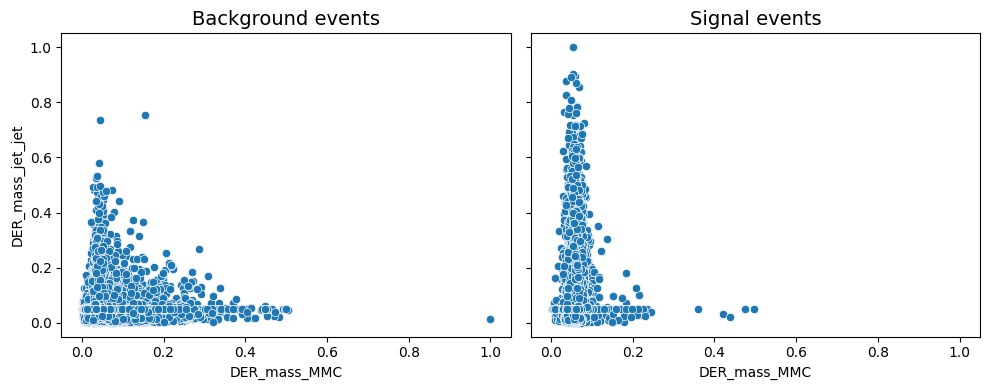

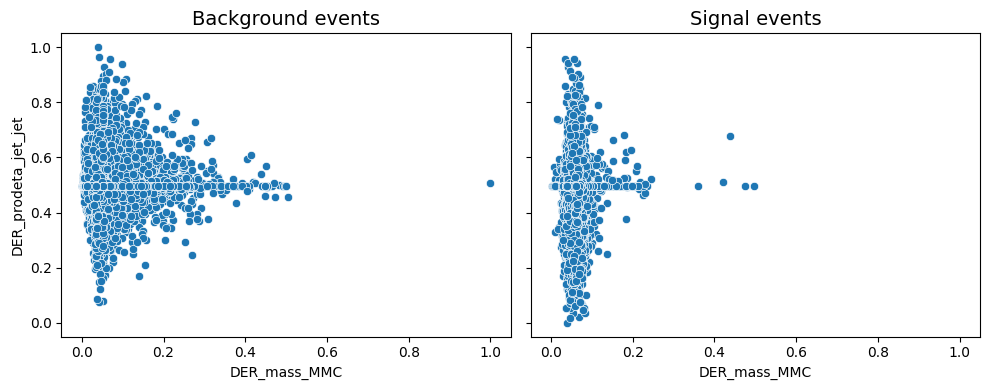

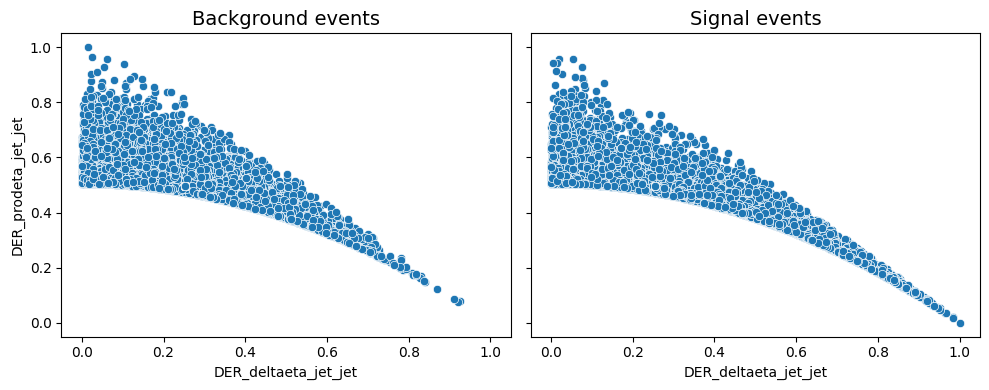

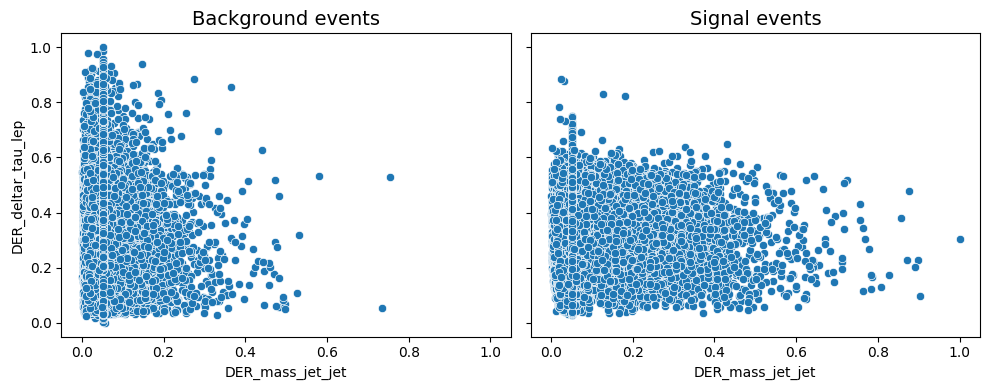

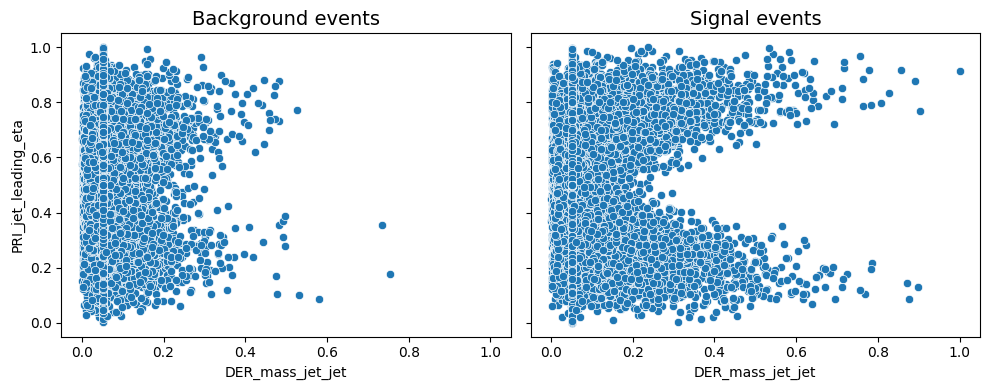

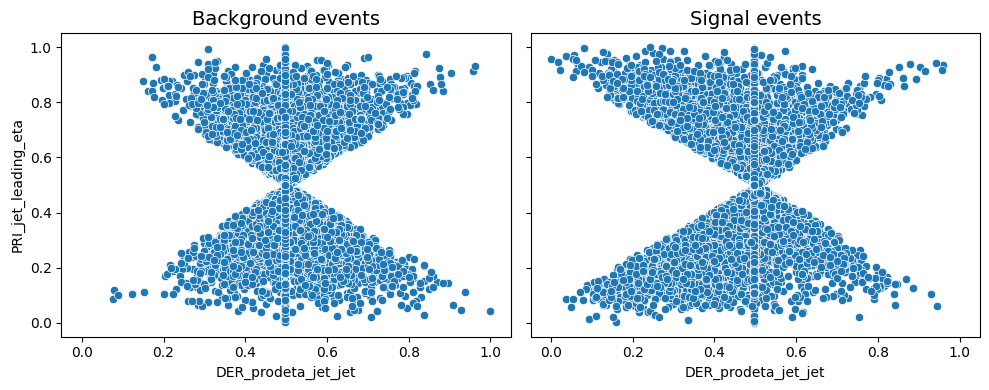

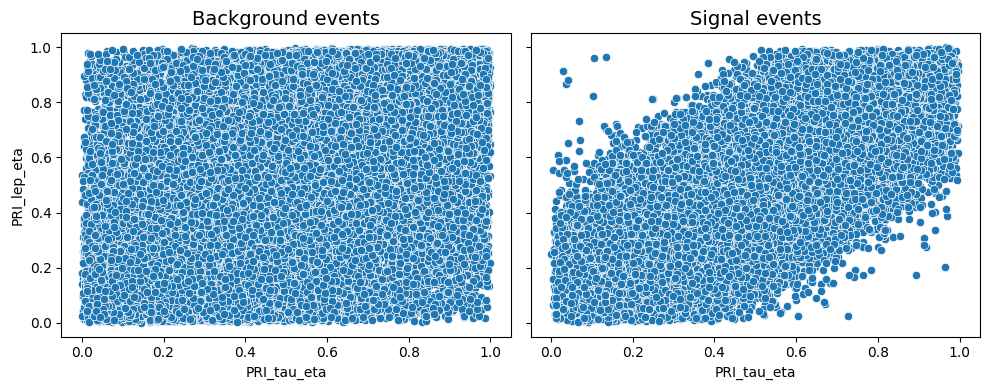

In [15]:

pairs_selected = [
    ('DER_mass_MMC', 'DER_mass_jet_jet'),
    ('DER_mass_MMC', 'DER_prodeta_jet_jet'),
    ('DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'),
    ('DER_mass_jet_jet', 'DER_deltar_tau_lep'),
    ('DER_mass_jet_jet', 'PRI_jet_leading_eta'),
    ('DER_prodeta_jet_jet', 'PRI_jet_leading_eta'),
    ('PRI_tau_eta', 'PRI_lep_eta'),
]
for z in pairs_selected:
    fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex = True, sharey = True)
    sns.scatterplot(data = X[Y['Label'] == 0], x = z[0], y = z[1], ax = ax[0])
    sns.scatterplot(data = X[Y['Label'] == 1], x = z[0], y = z[1], ax = ax[1])
    ax[0].set_title("Background events", fontsize = 14)
    ax[1].set_title("Signal events", fontsize = 14)
    plt.tight_layout()

plt.show()

###  Unbalance Ratio


<Axes: title={'center': 'Count (target)'}, xlabel='Label'>

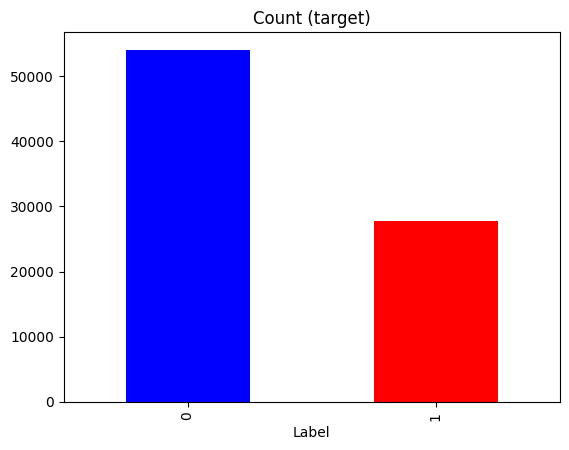

In [16]:
Y['Label'].value_counts().plot(kind='bar', title='Count (target)', color=['blue', 'red'])

The data can be considered as balance as the proportion of 0 and 1 instances are of the same order of magnitude.

### 7- Splitting into Train and Test

Separate the input data from the target and split the dataset into train and test sets (30% for testing).


In [ ]:
#subdivision des données éch.test = 30%
from sklearn.model_selection import train_test_split    
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

y_train = y_train_temp['Label']
y_test = y_test_temp['Label']
weight_train = y_train_temp['Weight']
weight_test = y_test_temp['Weight']


### 8- Dimension reduction

The choice of reducing the input dimensionality is highly debatable.
We know that some methods, including the ones we use, are strongly robust to dimensionality scaling, such as logistic regression (not optimized with inversion) or random forests. These models can take advantage of the input dimensionality by selecting the most relevant variables.

Here, for pedagogical reasons, we will consider this approximation (even though we observed that it often leads to a 10% reduction in performance) and apply a 90% PCA.

In the context of this physics experiment, many variables can be derived from one another, so dimensionality reduction makes a lot of sense. In some cases, these data are linearly correlated, where PCA shows excellent performance.

For other cases, using nonlinear methods to encode information makes more sense (QNN). Therefore, we explore information compression techniques such as Autoencoders in the last section, which seem like an interesting approach.

Number of principal components retained:  8 for 80% variance
Dimensions reduced from  33 to  8

Number of principal components retained:  10 for 90% variance
Dimensions reduced from  33 to  10


Text(0.5, 0, 'Number of component')

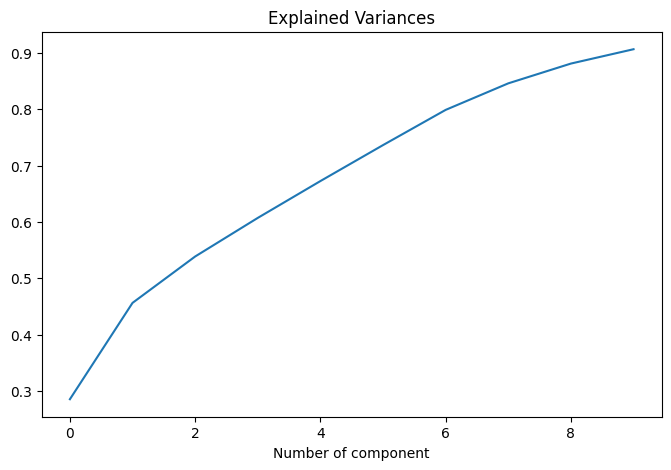

In [57]:
from sklearn.decomposition import PCA

# Fit PCA to retain 80% of the variance
pca = PCA(n_components=0.8).fit(X)

# Transform training and test data
X_train_pca_80 = pca.transform(X_train)
X_test_pca_80 = pca.transform(X_test)

print("Number of principal components retained: ", pca.n_components_, "for 80% variance")
print("Dimensions reduced from ", X_train.shape[1], "to ", X_train_pca_80.shape[1])
print()

# Import PCA class
from sklearn.decomposition import PCA

# Apply PCA retaining 90% of the variance
pca = PCA(n_components=0.9).fit(X)

# Transform training and test data
X_train_pca_90 = pca.transform(X_train)
X_test_pca_90 = pca.transform(X_test)

print("Number of principal components retained: ", pca.n_components_, "for 90% variance")
print("Dimensions reduced from ", X_train.shape[1], "to ", X_train_pca_90.shape[1])

# Plot the cumulative explained variance ratio
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variances')
plt.xlabel('Number of component')


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6545 samples in 0.000s...
[t-SNE] Computed neighbors for 6545 samples in 0.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6545
[t-SNE] Computed conditional probabilities for sample 2000 / 6545
[t-SNE] Computed conditional probabilities for sample 3000 / 6545
[t-SNE] Computed conditional probabilities for sample 4000 / 6545
[t-SNE] Computed conditional probabilities for sample 5000 / 6545
[t-SNE] Computed conditional probabilities for sample 6000 / 6545
[t-SNE] Computed conditional probabilities for sample 6545 / 6545
[t-SNE] Mean sigma: 0.229808
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.086693
[t-SNE] KL divergence after 1000 iterations: 1.223135
t-SNE done! Time elapsed: 25.668785572052002 seconds
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6545 samples in 0.019s...
[t-SNE] Computed neighbors for 6545 samples in 0.282s...
[t-SNE] Computed conditional probabiliti

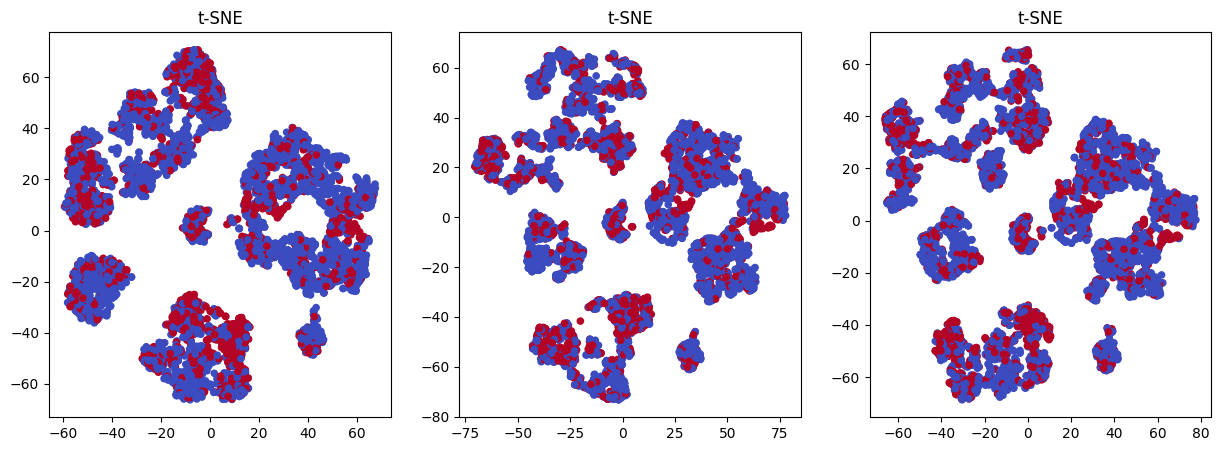

In [58]:
# # TSNE for initial data, pca 80% and pca 90%

# from sklearn.manifold import TSNE

# plt.figure(figsize=(15, 5))
# lenght = X_train.shape[0]
# propotion = .1
# for i, data in enumerate([X_train[:int(lenght*propotion)], X_train_pca_80[:int(lenght*propotion)], X_train_pca_90[:int(lenght*propotion)]]):
#     time_start = time.time()
#     tsne = TSNE(n_components=2, verbose=1, perplexity=40)
#     tsne_results = tsne.fit_transform(data)
#     print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
#     plt.subplot(1, 3, i+1)
#     plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_train[:int(lenght*propotion)], cmap=plt.cm.coolwarm, s=20)
#     plt.title('t-SNE')

For datasets with high dissimilarity between classes, an interesting approach is to verify that the dimensionality reduction preserves this dissimilarity. To achieve this, we can use geometric tools such as t-SNE in 2D and ensure that the dissimilarity is maintained.

Here, this step is not necessary because the class distributions are relatively similar, at least when measured using the Euclidean distance in the input space.

# I - Models Only (No additional Paradigms)

## 1- Decision Tree

In [152]:
#for saving results
results=  pd.DataFrame(columns= ["accuracy_score", "f1_score", "ams_score"])
list_accuracies=[]
list_F1=[]
list_times=[]
list_ams = []

Execution time :  2.268718957901001
accuray :  0.6667277726856096
F1 Score :  0.5184531167225852
AMS Score :  0.16826240565213862


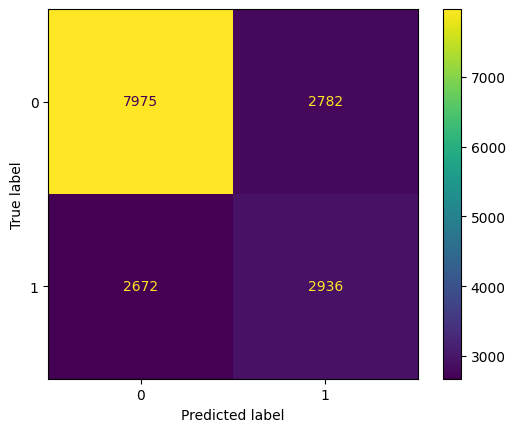

In [153]:
from sklearn.tree import DecisionTreeClassifier
#création d'une instance d'un classieur DecisionTree
dt_class= DecisionTreeClassifier()
deb = time.time()

dt_class.fit(X_train_pca_90, y_train)
fin=time.time()
res_dt = dt_class.predict(X_test_pca_90)
print("Execution time : ",(fin-deb))
list_times.append(fin-deb)
acc=accuracy_score(res_dt,y_test)
F1=f1_score(res_dt,y_test)
AMS = compute_ams_with_labels(y_test, res_dt, weight_test)
print("accuray : ",acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

classes=['Signal','Background']
cm = confusion_matrix(y_test, res_dt, labels=dt_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_class.classes_)
disp.plot()
plt.show()

As expected, a simple decision tree might struggle to handle the complexity of such a problem. There is a high bias induced by the model, as well as significant variance inherent in trees. The bagging and boosting paradigms might help to overcome these issues.

## 2- Logistic Regression

Execution time : 0.6112756729125977
Accuracy :  0.696547509929728
F1 Score :  0.3380431884830712
AMS Score :  0.09328653324572572


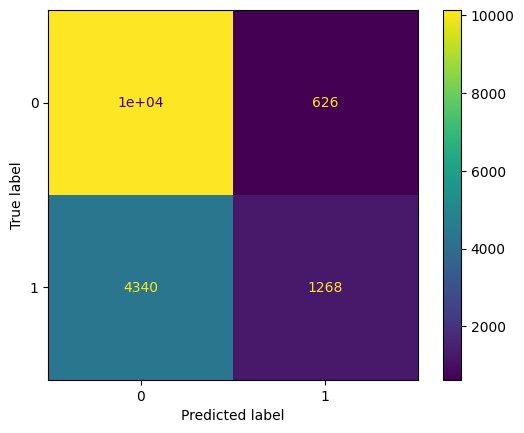

In [154]:
from sklearn.linear_model import LogisticRegression

# Création d'une instance du classifieur Logistic Regression
lg_clf = LogisticRegression(solver='sag') 
# Le solveur par défaut pour Logistic Regression est "liblinear", adapté aux petits problèmes.
# Ici, "sag" est utilisé pour les problèmes de grande taille.

deb = time.time()

# Si le training échoue, il faut relancer le code
lg_clf.fit(X_train_pca_90, y_train)

fin = time.time()

# Prédictions
res_lg = lg_clf.predict(X_test_pca_90)

# Temps de traitement
print("Execution time :", (fin - deb))
list_times.append(fin - deb)

# Calcul des métriques
acc = accuracy_score(res_lg, y_test)
F1 = f1_score(res_lg, y_test)
AMS = compute_ams_with_labels(y_test, res_lg, weight_test)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

# Stockage des résultats
list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

# Matrice de confusion
classes = ['Signal', 'Background']
cm = confusion_matrix(y_test, res_lg, labels=lg_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg_clf.classes_)
disp.plot()
plt.show()


The low accuracy of the logistic regression model might imply a highly non-linear relationship between the variables and the target.

##  3- Bayesien

Temps d'exécution : 0.1204080581665039
Accuracy :  0.6729605866177818
F1 Score :  0.39783978397839787
AMS Score :  0.09073497058885686


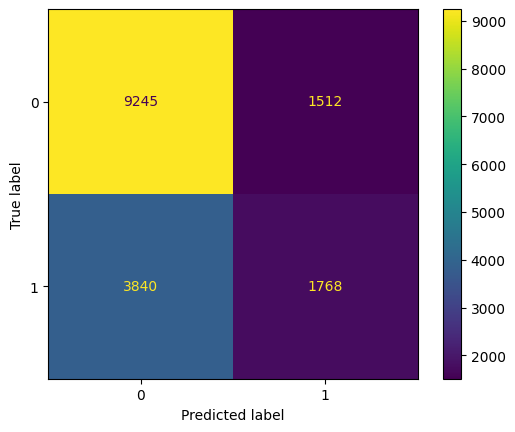

In [155]:
from sklearn.naive_bayes import GaussianNB

# Création d'une instance du classifieur Gaussian Naive Bayes
gn_clf = GaussianNB()

deb = time.time()

# Si le training échoue, il faut relancer le code
gn_clf.fit(X_train_pca_90, y_train)

fin = time.time()

# Prédictions
res_gn = gn_clf.predict(X_test_pca_90)

# Temps de traitement
print("Temps d'exécution :", (fin - deb))
list_times.append(fin - deb)

# Calcul des métriques
acc = accuracy_score(res_gn, y_test)
F1 = f1_score(res_gn, y_test)
AMS = compute_ams_with_labels(y_test, res_gn, weight_test)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

# Stockage des résultats
list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

# Matrice de confusion
classes = ['Signal', 'Background']
cm = confusion_matrix(y_test, res_gn, labels=gn_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gn_clf.classes_)
disp.plot()
plt.show()


At the moment, Naive Bayes shows strong performance compared to logistic regression. This suggests that a statistical approach could be of interest. It also invites us to consider neural networks as a potential solution.

### Plotting results

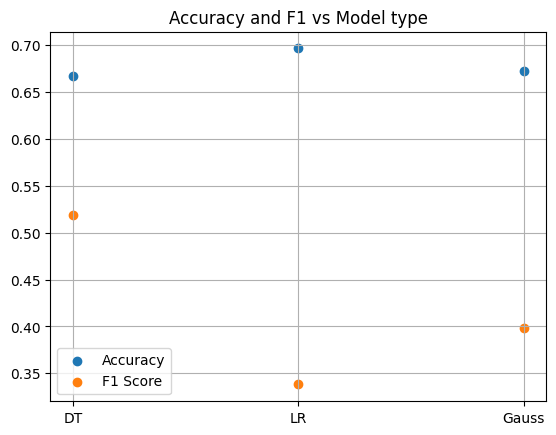

In [156]:
x = ['DT', 'LR', 'Gauss']
plt.grid()
plt.scatter(x,list_accuracies, label = "Accuracy")
plt.scatter(x,list_F1, label = "F1 Score")
plt.title("Accuracy and F1 vs Model type")
plt.legend()
#ajouter une légende
#....
plt.show()

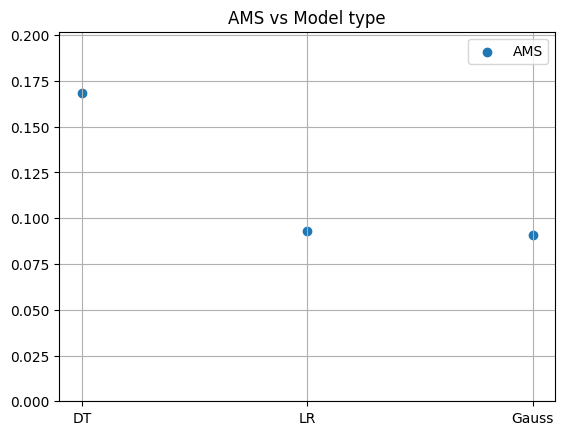

In [157]:
x = ['DT', 'LR', 'Gauss']
plt.grid()
plt.scatter(x,list_ams, label = "AMS")
plt.title("AMS vs Model type")
plt.legend()
plt.ylim(0,np.max(list_ams)*1.2)
#ajouter une légende
#....
plt.show()

# II - Bagging

Bagging (Bootstrap Aggregating) is an ensemble learning method that improves the stability and accuracy of machine learning algorithms. It involves creating multiple subsets of the original dataset through bootstrapping, training separate instances of a base learning algorithm on each subset, and aggregating the predictions.

Benefits of Bagging:

    Reduces Variance: Helps prevent overfitting by averaging predictions from multiple models.
    Improves Stability: Makes the model more robust by training on different data subsets.
    Handles Noisy Data: Mitigates the impact of outliers and noisy observations.


### Random Forest


Temps d'exécution : 88.50753116607666
Accuracy :  0.7344943476932478
F1 Score :  0.5586592178770949
AMS Score :  0.22978140576276493


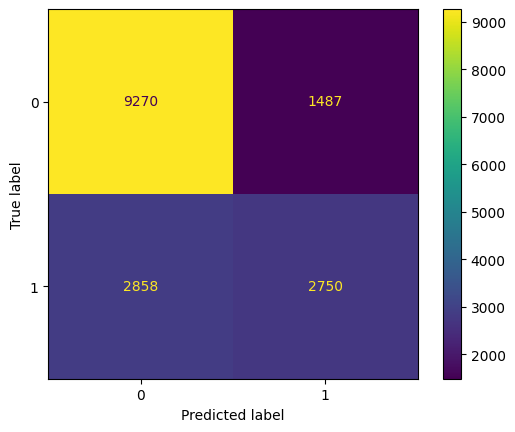

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt


# Création d'une instance de Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    # max_depth=None,
    # min_samples_split=2,
    # min_samples_leaf=1,
    # max_features='sqrt',
    # bootstrap=True,
    # random_state=42,  # Pour reproductibilité
)

# Mesure du temps d'entraînement
deb = time.time()

# Entraînement du modèle
rf.fit(X_train_pca_90, y_train)

fin = time.time()

# Prédictions
res_rf = rf.predict(X_test_pca_90)

# Temps de traitement
print("Temps d'exécution :", (fin - deb))
list_times.append(fin - deb)

# Calcul des métriques
acc = accuracy_score(res_rf, y_test)
F1 = f1_score(res_rf, y_test)
AMS = compute_ams_with_labels(y_test, res_rf, weight_test)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

# Stockage des résultats
list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

# Matrice de confusion
classes = ['Signal', 'Background']
cm = confusion_matrix(y_test, res_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()


Bagging effectively improves the performance of decision trees by addressing their high variance. By aggregating predictions from multiple trees trained on different subsets of the data, bagging reduces overfitting and enhances overall model stability and accuracy. However, the trade-off is that the training and generation of these multiple models take longer.

### Bagging classifier with Logistic Regression

Temps d'exécution : 0.8222010135650635
Accuracy :  0.6967919340054995
F1 Score :  0.33857637963209813
AMS Score :  0.09269869160130753


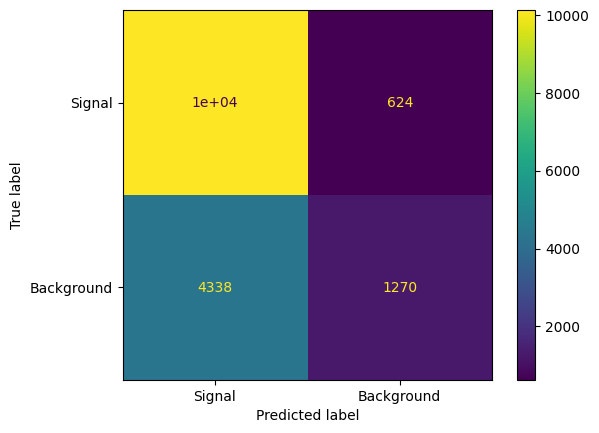

In [159]:
from sklearn.ensemble import BaggingClassifier
#max_samples: taille maximale de l'échantillon par rapport à l'échantillon initial
#max_features: nombre d'attributs à sélectionner d'une façon aléatoire
# max_features=1,random_state=0

# Création d'une instance de BaggingClassifier
bagging_clf = BaggingClassifier(
    LogisticRegression(),  # Utilise un DecisionTreeClassifier par défaut si None
    n_estimators=10,      # Nombre d'estimateurs dans l'ensemble
    max_samples=0.8,      # Taille maximale de l'échantillon (proportion de l'échantillon initial)
    max_features=1.0,     # Nombre de features à sélectionner aléatoirement (1.0 = tous les features)
    bootstrap=True,       # Échantillonnage avec remise
    bootstrap_features=False,  # Pas d'échantillonnage des features
    random_state=42       # Pour reproductibilité
)

# Mesure du temps d'entraînement
deb = time.time()

# Entraînement du modèle
bagging_clf.fit(X_train_pca_90, y_train)

fin = time.time()

# Prédictions
res_bagging = bagging_clf.predict(X_test_pca_90)

# Temps de traitement
print("Temps d'exécution :", (fin - deb))
list_times.append(fin - deb)

# Calcul des métriques
acc = accuracy_score(res_bagging, y_test)
F1 = f1_score(res_bagging, y_test)
AMS = compute_ams_with_labels(y_test, res_bagging, weight_test)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

# Stockage des résultats
list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

# Matrice de confusion
classes = ['Signal', 'Background']
cm = confusion_matrix(y_test, res_bagging)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()


Here, there is no notable improvement. Indeed, regression methods seek the best hyperplane, and bagging somewhat distorts this hyperplane. We lose the strength of linear regression, but in return, we gain the ability to capture non-linearity, which can be useful in certain cases. However, linear regressions are generally not well-suited for non-linear data, so using bagging in this context does not make much sense

### Bagging classifier with Baysian


temp :  2.5354113578796387
accuracy :  0.6731439046746105
F1 Score :  0.3986509274873524
AMS :  0.09109976362490058


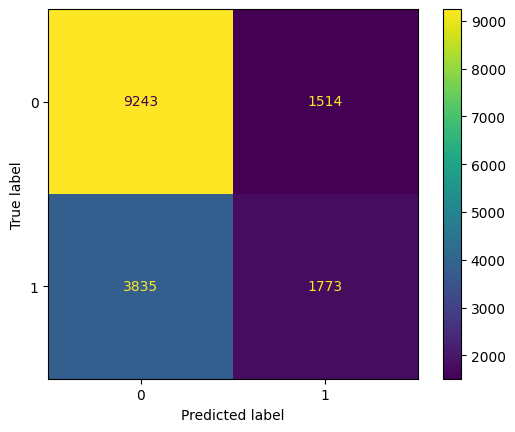

In [160]:
#max_samples: taille maximale de l'échantillon par rapport à l'échantillon initial
#max_features: nombre d'attributs à sélectionner d'une façon aléatoire
# max_features=1,random_state=0
#bagging = BaggingClassifier(GaussianNB(),n_estimators=50,max_samples=0.1,n_jobs=-1)
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(GaussianNB(),n_estimators=50,max_samples=0.1)
deb = time.time()
bagging.fit(X_train_pca_90, y_train)
fin=time.time()
list_times.append(fin-deb)
res_bag = bagging.predict(X_test_pca_90)
print("temp : ",(fin-deb))
acc=accuracy_score(res_bag,y_test)
F1=f1_score(res_bag,y_test)
AMS = compute_ams_with_labels(y_test, res_bag, weight_test)

print("accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS : ", AMS)
list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

cm = confusion_matrix(y_test, res_bag, labels=bagging.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=bagging.classes_)
disp.plot()
plt.show()

For Naive Bayes, as expected, there is kind of a statistical equivalence between bagging and the initial approach. Leading to similar results.

### Plotting results

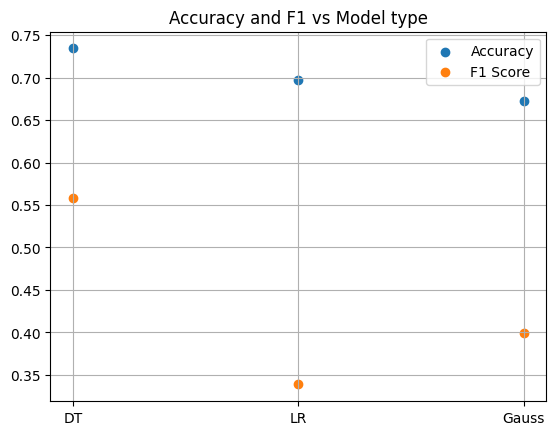

In [161]:
# x = ['DT', 'LR', 'Gauss', "RF", "Bag LR", "Bag Gauss"]
x_bagging = ["RF", "Bag LR", "Bag Gauss"]

plt.grid()
plt.scatter(x[-3:],list_accuracies[-3:], label = "Accuracy")
plt.scatter(x[-3:],list_F1[-3:], label = "F1 Score")
plt.title("Accuracy and F1 vs Model type")
plt.legend()
plt.show()

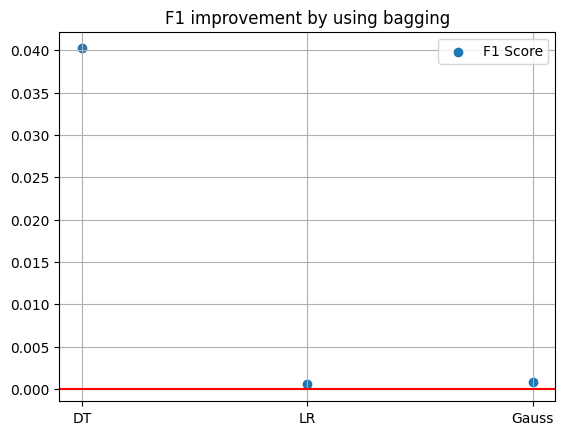

In [162]:
#figures des temps de calcul
x = ['DT', 'LR', 'Gauss', "RF", "Bag LR", "Bag Gauss"]
# x_bagging = ["RF", "Bag LR", "Bag Gauss"]

plt.grid()
# plt.scatter(x_bagging,list_accuracies_bagging, label = "Accuracy")
plt.scatter(x[:3],np.array(list_F1[-3:]) - np.array(list_F1[:3]), label = "F1 Score")
plt.axhline(y = 0, c = 'r')
plt.title("F1 improvement by using bagging")
plt.legend()
#ajouter une légende
#....
plt.show()

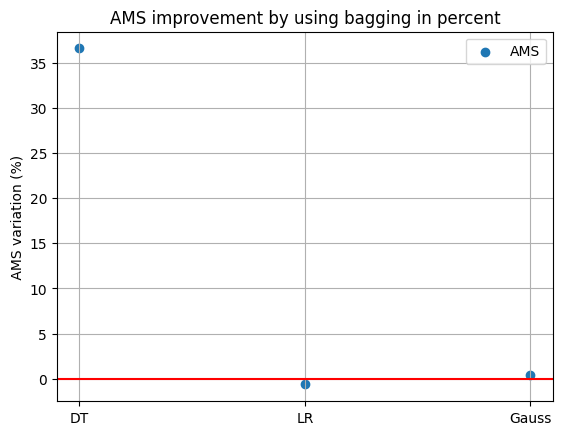

In [163]:
# x = ['DT', 'LR', 'Gauss', "RF", "Bag LR", "Bag Gauss"]
x_bagging = ["RF", "Bag LR", "Bag Gauss"]

plt.grid()
plt.scatter(x[:3],(np.array(list_ams[-3:]) - np.array(list_ams[:3]) )/ np.array(list_ams[:3])*100, label = "AMS")
plt.axhline(y = 0, c = 'r')
plt.ylabel(' AMS variation (%) ')
plt.title("AMS improvement by using bagging in percent")
plt.legend()
plt.show()

# III - Boosting

Boosting is an ensemble learning technique that sequentially trains multiple weak learners to create a strong predictive model. Each new model focuses on correcting the errors made by the previous models, with data points that were misclassified by earlier models being given higher weights.

Benefits of Boosting:
    Reduces Bias and Variance: By combining multiple weak learners, boosting can reduce both bias and variance, leading to improved overall performance.
    Focuses on Hard-to-Predict Instances: Boosting concentrates on the difficult cases, continually refining the model to handle these better.

## Gradient Boost (Gradient Boosted Decision Trees)

This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced.



c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Temps d'exécution : 0.8046154975891113
Accuracy :  0.7377940727161626
F1 Score :  0.5526946731992077
AMS Score :  0.24131876234106253


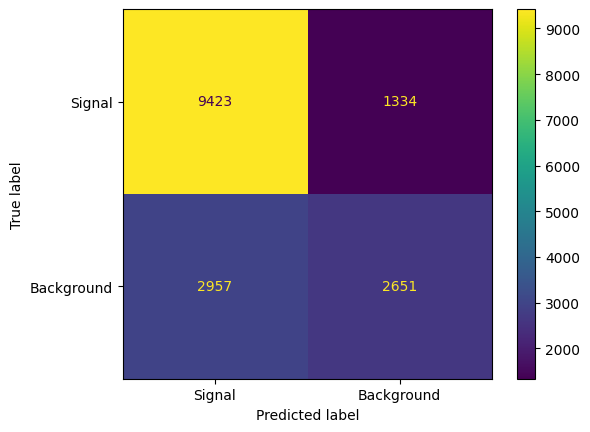

In [164]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt

# Création d'une instance de XGBoostClassifier
xgboost_clf = XGBClassifier(
    n_estimators=100,         # Nombre d'arbres
    learning_rate=0.1,        # Taux d'apprentissage
    max_depth=6,              # Profondeur maximale des arbres
    subsample=0.8,            # Fraction des échantillons utilisés pour entraîner chaque arbre
    colsample_bytree=0.8,     # Fraction des features utilisées pour chaque arbre
    objective='binary:logistic',  # Fonction objectif pour la classification binaire
    random_state=42,          # Pour reproductibilité
    use_label_encoder=False,  # Désactive l'encodeur automatique des labels
    eval_metric='logloss'     # Métrique d'évaluation
)

# Mesure du temps d'entraînement
deb = time.time()

# Entraînement du modèle
xgboost_clf.fit(X_train_pca_90, y_train)

fin = time.time()

# Prédictions
res_xgboost = xgboost_clf.predict(X_test_pca_90)

# Temps de traitement
print("Temps d'exécution :", (fin - deb))
list_times.append(fin - deb)

# Calcul des métriques
acc = accuracy_score(res_xgboost, y_test)
F1 = f1_score(res_xgboost, y_test)
AMS = compute_ams_with_labels(y_test, res_xgboost, weight_test)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

# Stockage des résultats
list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

# Matrice de confusion
classes = ['Signal', 'Background']
cm = confusion_matrix(y_test, res_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

### AdaBoost on logistic regression

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

Temps d'exécution : 1.2507359981536865
Accuracy :  0.6987473266116713
F1 Score :  0.4698924731182796
AMS Score :  0.11925163957962555


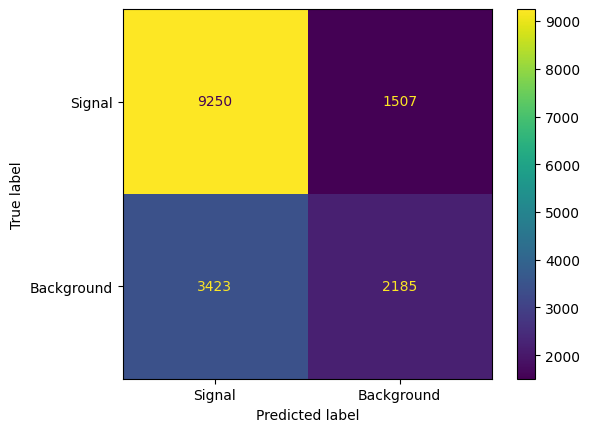

In [165]:
from sklearn.ensemble import AdaBoostClassifier
import time
import matplotlib.pyplot as plt

# Création d'une instance de AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(
    LogisticRegression(),  # Utilise un DecisionTreeClassifier par défaut si None
    n_estimators=50,      # Nombre d'estimateurs dans l'ensemble
    learning_rate=1.0,    # Taux d'apprentissage pour le pondération des estimateurs
    algorithm='SAMME',  # Utilise SAMME.R (Real boosting algorithm), SAMME pour classification discrète
    random_state=42       # Pour reproductibilité
)

# Mesure du temps d'entraînement
deb = time.time()

# Entraînement du modèle
adaboost_clf.fit(X_train_pca_90, y_train)

fin = time.time()

# Prédictions
res_adaboost = adaboost_clf.predict(X_test_pca_90)

# Temps de traitement
print("Temps d'exécution :", (fin - deb))
list_times.append(fin - deb)

# Calcul des métriques
acc = accuracy_score(res_adaboost, y_test)
F1 = f1_score(res_adaboost, y_test)
AMS = compute_ams_with_labels(y_test, res_adaboost, weight_test)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

# Stockage des résultats
list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

# Matrice de confusion
classes = ['Signal', 'Background']
cm = confusion_matrix(y_test, res_adaboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()


Boosted regression improves performance by applying different linear transformations to misclassified data, which can enhance the expressivity of the model. For example, consider regressing on a triangular shape, which would be challenging with a single linear model but becomes feasible with boosting.

Temps d'exécution : 0.892235279083252
Accuracy :  0.6923923006416132
F1 Score :  0.46853885135135137
AMS Score :  0.1226436925901385


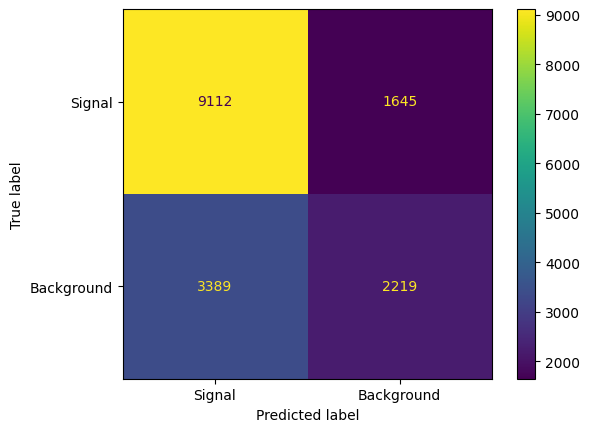

In [166]:
from sklearn.ensemble import AdaBoostClassifier
import time
import matplotlib.pyplot as plt

# Création d'une instance de AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(
    GaussianNB(),  # Utilise un DecisionTreeClassifier par défaut si None
    n_estimators=50,      # Nombre d'estimateurs dans l'ensemble
    learning_rate=1.0,    # Taux d'apprentissage pour le pondération des estimateurs
    algorithm='SAMME',  # Utilise SAMME.R (Real boosting algorithm), SAMME pour classification discrète
    random_state=42       # Pour reproductibilité
)

# Mesure du temps d'entraînement
deb = time.time()

# Entraînement du modèle
adaboost_clf.fit(X_train_pca_90, y_train)

fin = time.time()

# Prédictions
res_adaboost = adaboost_clf.predict(X_test_pca_90)

# Temps de traitement
print("Temps d'exécution :", (fin - deb))
list_times.append(fin - deb)

# Calcul des métriques
acc = accuracy_score(res_adaboost, y_test)
F1 = f1_score(res_adaboost, y_test)
AMS = compute_ams_with_labels(y_test, res_adaboost, weight_test)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

# Stockage des résultats
list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

# Matrice de confusion
classes = ['Signal', 'Background']
cm = confusion_matrix(y_test, res_adaboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()


Even though boosting can enhance performance, it can quickly lead to overfitting, especially for statistical methods where the number of data points used for estimation is reduced. This explains why the results for Naive Bayes are not mind-blowing when boosting is applied.

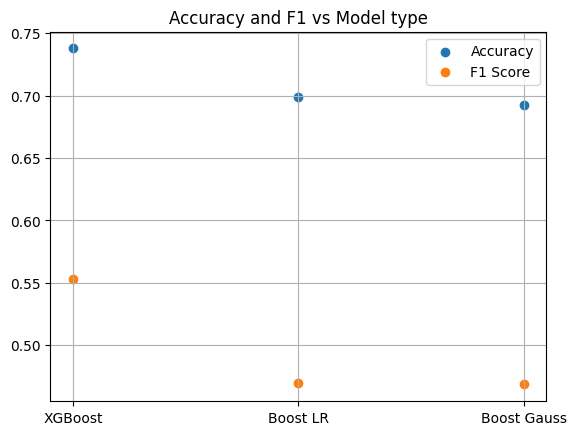

In [169]:
x = ['DT', 'LR', 'Gauss', "RF", "Bag LR", "Bag Gauss", "XGBoost", "Boost LR", "Boost Gauss" ]

plt.grid()
plt.scatter(x[-3:],list_accuracies[-3:], label = "Accuracy")
plt.scatter(x[-3:],list_F1[-3:], label = "F1 Score")
plt.title("Accuracy and F1 vs Model type")
plt.legend()

plt.show()

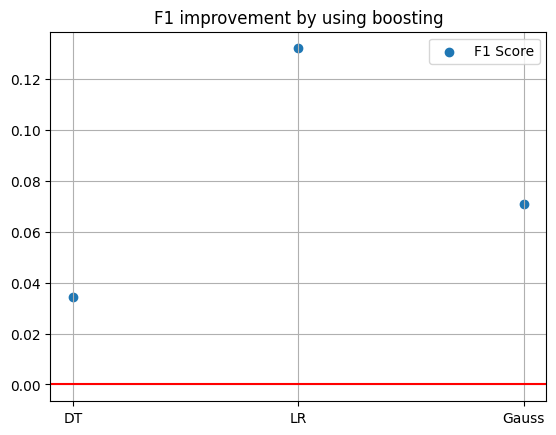

In [170]:
plt.grid()
# plt.scatter(x_bagging,list_accuracies_bagging, label = "Accuracy")
plt.scatter(x[:3],np.array(list_F1[-3:]) - np.array(list_F1[:3]), label = "F1 Score")
plt.axhline(y = 0, c = 'r')
plt.title("F1 improvement by using boosting")
plt.legend()
plt.show()

# IV - Balancing the Data

## (i) Under Sampling

In [168]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
#Under Sampling
us = RandomUnderSampler(random_state=1)
x_us, y_us = us.fit_resample(X_train_pca_90, y_train)

## (ii) Over Sampling

In [171]:
os = RandomOverSampler(random_state=1)
x_os, y_os = os.fit_resample(X_train_pca_90, y_train)

## (iii) SMOTE

In [172]:
sm = SMOTE(random_state=1)
x_sm, y_sm = sm.fit_resample(X_train_pca_90, y_train)

## (iv) BSMOTE

In [173]:
bl = BorderlineSMOTE(random_state=1)
x_bl, y_bl = bl.fit_resample(X_train_pca_90, y_train)

We considered three models. The poor performance of the linear model (logistic regression) and its improvement via boosting suggest that we should deviate from the linear paradigm.

We might investigate Gaussian Naive Bayes more deeply for the probabilistic paradigm, even though it may still lack complexity. Perhaps we can explore neural networks as well. On the other hand, decision trees showed good performance when boosted and bagged. However, we chose Random Forests over XGBoost because XGBoost might overfit the synthetic data generated through augmentation.

In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# Initialisation des modèles
nb = GaussianNB()
rf = RandomForestClassifier(random_state=1)
lr = LogisticRegression()
# Initialisation des données rééchantillonnées
resampling_methods = [
    (X_train_pca_80,y_train, X_test_pca_80,  "PCA-80"),
    (x_us, y_us,X_test_pca_90, "Undersampling (PCA 90)"),
    (x_os, y_os, X_test_pca_90, "Oversampling (PCA 90)"),
    (x_sm, y_sm, X_test_pca_90, "SMOTE (PCA 90)"),
    (x_bl, y_bl, X_test_pca_90, "Borderline SMOTE (PCA 90)")
]

# Initialisation des modèles à tester
models = [
    (rf, "Random Forest"),
    (lr, "Logistic Regression"),
    (nb, "Naive Bayes")
]

# Stockage des résultats
results = []

# Entraînement et évaluation des modèles
for model, model_name in models:
    for training_x, training_y, testing_x, method_name in resampling_methods:
        # Entraînement du modèle
        model.fit(training_x, training_y)
        
        # Prédictions sur les données de test
        y_pred = model.predict(testing_x)
        
        # Calcul des métriques
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        AMS = compute_ams_with_labels(y_test, y_pred, weight_test)
        
        # Stockage des résultats
        results.append({
            "Model": model_name,
            "Method": method_name,
            "Accuracy": acc,
            "F1-Score": f1, 
            "AMS" : AMS
        })

# Création d'un DataFrame avec les résultats
results_df = pd.DataFrame(results)

# Trier par F1-score
results_sorted = results_df.sort_values(by="F1-Score", ascending=False)

# Afficher les résultats triés
print(results_sorted)


                  Model                     Method  Accuracy  F1-Score  \
1         Random Forest     Undersampling (PCA 90)  0.703880  0.629000   
4         Random Forest  Borderline SMOTE (PCA 90)  0.715185  0.621703   
3         Random Forest             SMOTE (PCA 90)  0.722395  0.616657   
2         Random Forest      Oversampling (PCA 90)  0.728445  0.587908   
8   Logistic Regression             SMOTE (PCA 90)  0.665383  0.564429   
6   Logistic Regression     Undersampling (PCA 90)  0.665078  0.563719   
7   Logistic Regression      Oversampling (PCA 90)  0.664589  0.563221   
9   Logistic Regression  Borderline SMOTE (PCA 90)  0.653223  0.561945   
14          Naive Bayes  Borderline SMOTE (PCA 90)  0.633731  0.550270   
0         Random Forest                     PCA-80  0.730706  0.548971   
13          Naive Bayes             SMOTE (PCA 90)  0.653468  0.544754   
12          Naive Bayes      Oversampling (PCA 90)  0.653162  0.544243   
11          Naive Bayes     Undersampl

# IV - Neural Networks

In [175]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes= [10,10,5], activation= 'relu', solver = 'adam', learning_rate= "adaptive", max_iter=100, batch_size= 100)

nn.fit(X_train_pca_90, y_train)

y_pred = nn.predict(X_test_pca_90)

# Calcul des métriques
acc = accuracy_score(y_pred, y_test)
F1 = f1_score(y_pred, y_test)
AMS = compute_ams_with_labels(y_test, y_pred, weight_test)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)


Accuracy :  0.7329666972196761
F1 Score :  0.5207282298749726
AMS Score :  0.23402668608659938


c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


We can see that neural networks have similar performance to random forests (without balancing). In fact, the F1 score even gives an advantage to random forests.

In [ ]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes= [10,10,5], activation= 'tanh', solver = 'adam', learning_rate= "adaptive", max_iter=150, batch_size= 100)

nn.fit(x_sm, y_sm)

y_pred = nn.predict(X_test_pca_90)

# Calcul des métriques
acc = accuracy_score(y_pred, y_test)
F1 = f1_score(y_pred, y_test)
# AMS = compute_ams_with_labels(res_adaboost, y_test, Weights_values)

print("Accuracy : ", acc)
print("F1 Score : ", F1)
# print("AMS Score : ", AMS)


Accuracy :  0.7023525817293004
F1 Score :  0.6363025461061749


When trained on a balanced dataset, neural networks achieve the best F1 score due to their ability to capture complex relationships, learn relevant features, and adapt to the dataset. However, these results can vary with fine-tuning of different methods.

# V - Evolutionnary Algorithms (LEAP)

## (A) Decision Tree

In [ ]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification


# Définition de l'objectif à minimiser (erreur, donc on maximise les scores négatifs)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Toolbox pour DEAP
toolbox = base.Toolbox()

# Définir les hyperparamètres à optimiser (par exemple max_depth, min_samples_split)
toolbox.register("attr_max_depth", random.randint, 2, 20)
toolbox.register("attr_min_samples_split", random.randint, 2, 10)

# Génération d'un individu et d'une population
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_max_depth, toolbox.attr_min_samples_split))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fonction d'évaluation
def evaluate(individual):
    max_depth, min_samples_split = individual
    max_depth = max(2, int(round(max_depth)))  # Ensure max_depth is at least 1
    min_samples_split = max(2,int(round(min_samples_split)))  # Ensure min_samples_split is an integer
    clf = DecisionTreeClassifier(max_depth=max_depth,
                                 min_samples_split=min_samples_split)
    scores = cross_val_score(clf, X_train_pca_90, y_train, cv=5, scoring="accuracy")
    return np.mean(scores),

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Paramètres de l'algorithme évolutif
pop = toolbox.population(n=50)
ngen = 20
cxpb = 0.5
mutpb = 0.2

# Exécution de l'algorithme évolutif
best_individuals = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb,
                                       ngen=ngen, verbose=True)

# Affichage du meilleur individu
best_individual = tools.selBest(pop, k=1)[0]
print("Best Parameters:", best_individual)


c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	39    
2  	32    
3  	34    
4  	28    
5  	31    
6  	27    
7  	22    
8  	41    
9  	32    
10 	27    
11 	24    
12 	38    
13 	29    
14 	24    
15 	26    
16 	31    
17 	28    
18 	31    
19 	37    
20 	36    
Best Parameters: [10.30464012294174, 1.614408809678189]


Execution time :  1.3098735809326172
accuray :  0.7040024442407578
F1 Score :  0.47071678321678323
AMS Score :  0.16253180630131558


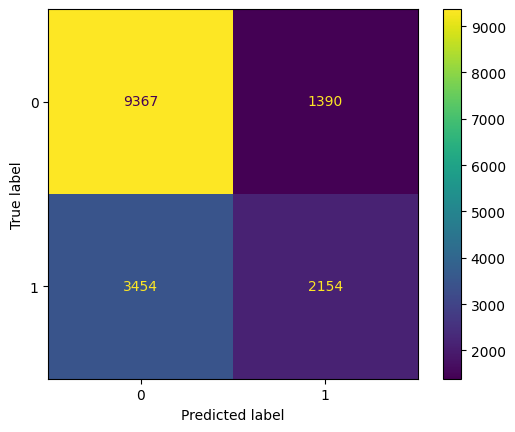

In [189]:
from sklearn.tree import DecisionTreeClassifier
#création d'une instance d'un classieur DecisionTree
dt_class= DecisionTreeClassifier(max_depth=10, min_samples_split=2)
deb = time.time()

dt_class.fit(X_train_pca_90, y_train)
fin=time.time()
res_dt = dt_class.predict(X_test_pca_90)
print("Execution time : ",(fin-deb))
list_times.append(fin-deb)
acc=accuracy_score(res_dt,y_test)
F1=f1_score(res_dt,y_test)
AMS = compute_ams_with_labels(y_test, res_dt, weight_test)
print("accuray : ",acc)
print("F1 Score : ", F1)
print("AMS Score : ", AMS)

list_accuracies.append(acc)
list_F1.append(F1)
list_ams.append(AMS)

classes=['Signal','Background']
cm = confusion_matrix(y_test, res_dt, labels=dt_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_class.classes_)
disp.plot()
plt.show()

## (B) Neural Networks

In [190]:
from sklearn.neural_network import MLPClassifier

# Génération de données de classification (réutilisation des données X, y)
activations = ['relu', 'tanh']

# Ajouter des fonctions à optimiser (par exemple, activation, hidden layers)
toolbox.register("attr_hidden_layer", random.randint, 10, 100)
toolbox.register("attr_activation", random.choice, activations)
toolbox.register("attr_residuals", random.randint, 0, 1)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_hidden_layer, toolbox.attr_activation,
                  toolbox.attr_residuals))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fonction d'évaluation
def evaluate_nn(individual):
    hidden_layer, activation, residuals = individual
    hidden_layer_sizes = (hidden_layer,) * (2 if residuals else 1)
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation,
                        max_iter=200, random_state=42)
    scores = cross_val_score(clf, X_train_pca_90, y_train, cv=5, scoring="accuracy")
    return np.mean(scores),

toolbox.register("evaluate", evaluate_nn)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Exécution de l'algorithme évolutif pour le réseau de neurones
pop = toolbox.population(n=10)
best_individuals_nn = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb,
                                          ngen=ngen, verbose=True)

# Affichage du meilleur individu
best_nn = tools.selBest(pop, k=1)[0]
print("Best Parameters for Neural Network:", best_nn)


c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the 

gen	nevals
0  	10    


TypeError: can't multiply sequence by non-int of type 'float'

# VI - Quantum Neural Networks 

Here a ludic test of a variatonnal quantum neural network
We will apply our quantum neural network to a low data and higly noised setting ( due to the dimension reduction).

## (i) Data Reduction with Auto Encoder and Under sampling

In [ ]:
import torch
from torch import nn
from my_AutoEncoder_toolbox import training, AutoEncoder
# from AE import AutoEncoder
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# number of qubit will correspond to the dim of reduction
num_qubits = 4

# Assuming X_train and y_train are NumPy arrays, convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataloader = DataLoader(X_train_tensor, batch_size=8, shuffle=True)
test_dataloader = DataLoader(X_test_tensor, batch_size=8, shuffle=False)


# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = AutoEncoder(input_dim, num_qubits)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 30
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

training(model, train_dataloader, test_dataloader, num_epochs, optimizer, criterion)


# Extract reduced dimensions (encoded representation)
model.eval()
with torch.no_grad():
    X_train_ae = model.encoder(X_train_tensor.to(device)).cpu().numpy()
    X_test_ae = model.encoder(X_test_tensor.to(device)).cpu().numpy()

print("Dimension reduction complete.")

X_train_ae_reduced = X_train_ae[:800]
y_train_reduced = y_train[:800]
X_test_ae_reduced = X_train_ae[800:1000]
y_test_reduced = y_train[800:1000]

print("Restriciton du nombre de données complete")


100%|██████████| 8183/8183 [00:12<00:00, 660.49it/s]


Epoch 1/30, Train Loss: 0.0422, Test Loss: 0.0300


100%|██████████| 8183/8183 [00:12<00:00, 670.30it/s]


Epoch 2/30, Train Loss: 0.0248, Test Loss: 0.0236


100%|██████████| 8183/8183 [00:17<00:00, 464.88it/s]


Epoch 3/30, Train Loss: 0.0231, Test Loss: 0.0225


100%|██████████| 8183/8183 [00:22<00:00, 356.55it/s]


Epoch 4/30, Train Loss: 0.0197, Test Loss: 0.0170


100%|██████████| 8183/8183 [00:20<00:00, 392.53it/s]


Epoch 5/30, Train Loss: 0.0161, Test Loss: 0.0156


100%|██████████| 8183/8183 [00:20<00:00, 401.22it/s]


Epoch 6/30, Train Loss: 0.0153, Test Loss: 0.0151


100%|██████████| 8183/8183 [00:20<00:00, 396.56it/s]


Epoch 7/30, Train Loss: 0.0146, Test Loss: 0.0142


100%|██████████| 8183/8183 [00:20<00:00, 404.71it/s]


Epoch 8/30, Train Loss: 0.0138, Test Loss: 0.0136


100%|██████████| 8183/8183 [00:18<00:00, 441.29it/s]


Epoch 9/30, Train Loss: 0.0133, Test Loss: 0.0132


100%|██████████| 8183/8183 [00:12<00:00, 660.36it/s]


Epoch 10/30, Train Loss: 0.0129, Test Loss: 0.0129


100%|██████████| 8183/8183 [00:12<00:00, 681.42it/s]


Epoch 11/30, Train Loss: 0.0127, Test Loss: 0.0127


100%|██████████| 8183/8183 [00:12<00:00, 644.47it/s]


Epoch 12/30, Train Loss: 0.0125, Test Loss: 0.0125


100%|██████████| 8183/8183 [00:12<00:00, 675.08it/s]


Epoch 13/30, Train Loss: 0.0123, Test Loss: 0.0123


100%|██████████| 8183/8183 [00:15<00:00, 517.03it/s]


Epoch 14/30, Train Loss: 0.0121, Test Loss: 0.0121


100%|██████████| 8183/8183 [00:13<00:00, 590.28it/s]


Epoch 15/30, Train Loss: 0.0119, Test Loss: 0.0119


100%|██████████| 8183/8183 [00:16<00:00, 491.73it/s]


Epoch 16/30, Train Loss: 0.0117, Test Loss: 0.0118


100%|██████████| 8183/8183 [00:20<00:00, 403.85it/s]


Epoch 17/30, Train Loss: 0.0116, Test Loss: 0.0116


100%|██████████| 8183/8183 [00:16<00:00, 509.19it/s]


Epoch 18/30, Train Loss: 0.0115, Test Loss: 0.0115


100%|██████████| 8183/8183 [00:12<00:00, 674.71it/s]


Epoch 19/30, Train Loss: 0.0114, Test Loss: 0.0115


100%|██████████| 8183/8183 [00:16<00:00, 511.25it/s]


Epoch 20/30, Train Loss: 0.0113, Test Loss: 0.0114


100%|██████████| 8183/8183 [00:21<00:00, 381.03it/s]


Epoch 21/30, Train Loss: 0.0113, Test Loss: 0.0113


100%|██████████| 8183/8183 [00:22<00:00, 371.66it/s]


Epoch 22/30, Train Loss: 0.0112, Test Loss: 0.0113


100%|██████████| 8183/8183 [00:25<00:00, 315.78it/s]


Epoch 23/30, Train Loss: 0.0112, Test Loss: 0.0113


100%|██████████| 8183/8183 [00:15<00:00, 526.16it/s]


Epoch 24/30, Train Loss: 0.0112, Test Loss: 0.0113


100%|██████████| 8183/8183 [00:17<00:00, 466.92it/s]


Epoch 25/30, Train Loss: 0.0111, Test Loss: 0.0112


100%|██████████| 8183/8183 [00:14<00:00, 565.66it/s]


Epoch 26/30, Train Loss: 0.0111, Test Loss: 0.0112


100%|██████████| 8183/8183 [00:16<00:00, 483.91it/s]


Epoch 27/30, Train Loss: 0.0111, Test Loss: 0.0112


100%|██████████| 8183/8183 [00:12<00:00, 649.46it/s]


Epoch 28/30, Train Loss: 0.0111, Test Loss: 0.0112


100%|██████████| 8183/8183 [00:13<00:00, 610.24it/s]


Epoch 29/30, Train Loss: 0.0110, Test Loss: 0.0111


100%|██████████| 8183/8183 [00:14<00:00, 574.56it/s]


Epoch 30/30, Train Loss: 0.0110, Test Loss: 0.0112
Dimension reduction complete.
Restriciton du nombre de données complete


In [ ]:
print("Final shape : ", X_train_ae_reduced.shape) 
print("A sample : ", X_train_ae_reduced[30,:])
print("Initial data sample: ", model.decoder(torch.tensor(X_train_ae[30,:])))
print("Reconstructed data sample: ", X_train.values[30,:])


Final shape :  (1000, 4)
A sample :  [3.4720652 0.        8.153145  5.4998293]
Initial data sample:  tensor([ 0.0555,  0.0577,  0.0507,  0.0838,  0.2571,  0.0486,  0.5011,  0.3776,
         0.0344,  0.0658,  0.0498,  0.8245,  0.4628,  0.0416,  0.2993,  0.5057,
         0.0387,  0.2950,  0.3636,  0.0541,  0.4729,  0.1128,  0.0507,  0.4378,
         0.5851,  0.0230,  0.4836,  0.5115,  0.0428, -0.0023,  0.9948,  0.0051,
        -0.0038], grad_fn=<ViewBackward0>)
Reconstructed data sample:  [0.04492967 0.06690588 0.04818896 0.0655608  0.25345074 0.05197925
 0.49752468 0.33052907 0.01168674 0.05293584 0.04924132 0.79809052
 0.469      0.03010836 0.49218437 0.20432845 0.04061078 0.31834532
 0.49538511 0.02313982 0.18268619 0.12085756 0.02777599 0.48591784
 0.84084036 0.02659773 0.49688612 0.49769219 0.03396217 0.
 1.         0.         0.        ]


## (ii) Choosing a feature map and an antzatz

A natural way to encode a feature in a quantum state is to apply a feature-proportional rotation to the qubit. That is what we are doing with the ZZ feature map (in a bit more complex version including repetitions...).
The ansatz choice is also a question of interest. Here, we want to explore a vast space, so we use two-qubit (controlled CX) gates between all following qubits, permitting entanglement with highly distant qubits. We also use single Rx, single Rz, and Rx rotations to explore two non-commuting bases and thus introduce diagonal elements in the final unitary.

In [105]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
# from qiskit.opflow import Z
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize
import numpy as np


# Define the feature map
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)

# Define the ansatz (TwoLocal circuit)
var_form_antsatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks=["rx", "rz"],  # Single-qubit rotations
    entanglement_blocks="cx",      # Controlled-X gates for entanglement
    entanglement="linear",         # Linear connectivity between qubits
    reps=2,                        # Number of repetitions
    insert_barriers=True           # Barriers for better visualization
)


ansatz = feature_map.compose(var_form_antsatz)

For the training we use the minimize routine from scipy.optimize

In [ ]:
from my_QNN_toolbox import cost_func_classification
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize


estimator = StatevectorEstimator()
observable = SparsePauliOp("Z" * num_qubits)


# Number of features (10-dimensional data mapped to 10 qubits)
num_features = num_qubits

# Initialize parameters for optimization
x0 = np.random.rand(ansatz.num_parameters - num_features)  # Only the ansatz parameters

# Define arguments for the cost function
args = (ansatz,observable, estimator, X_train_ae_reduced, y_train_reduced)

# Run the optimizer
result = minimize(
    fun=cost_func_classification,  # The cost function
    x0=x0,                        # Initial guess for the parameters
    args=args,                    # Additional arguments for the cost function
    method="COBYLA",              # Constrained optimization by linear approximations
    options={'maxiter': 100}      # Optional: limit the number of iterations
)

# Print the results
print("Optimal Parameters:", result.x)
print("Minimum Cost (Binary Cross-Entropy Loss):", result.fun)


1000it [00:11, 90.61it/s]
1000it [00:08, 117.92it/s]
1000it [00:08, 119.11it/s]
1000it [00:08, 121.10it/s]
1000it [00:08, 118.73it/s]
1000it [00:08, 114.92it/s]
1000it [00:08, 122.88it/s]
1000it [00:08, 123.76it/s]
1000it [00:08, 120.39it/s]
1000it [00:08, 114.17it/s]
1000it [00:08, 115.56it/s]
1000it [00:08, 118.02it/s]
1000it [00:08, 117.60it/s]
1000it [00:08, 115.98it/s]
1000it [00:08, 119.80it/s]
1000it [00:08, 115.20it/s]
1000it [00:08, 115.31it/s]
1000it [00:08, 114.95it/s]
1000it [00:08, 114.65it/s]
1000it [00:08, 116.80it/s]
1000it [00:09, 110.14it/s]
1000it [00:08, 118.37it/s]
1000it [00:08, 115.73it/s]
1000it [00:08, 116.82it/s]
1000it [00:08, 115.49it/s]
1000it [00:09, 106.58it/s]
1000it [00:08, 114.91it/s]
1000it [00:08, 112.03it/s]
1000it [00:09, 110.12it/s]
1000it [00:08, 118.90it/s]
1000it [00:09, 105.31it/s]
1000it [00:08, 119.15it/s]
1000it [00:08, 112.80it/s]
1000it [00:09, 109.03it/s]
1000it [00:09, 110.30it/s]
1000it [00:09, 110.80it/s]
1000it [00:08, 113.46it/s]
10

Optimal Parameters: [ 0.3624925   2.39711837  1.30103857  1.03977382 -0.51102295  1.1173328
  1.60218353  1.36903649  1.42796236  1.81995087  2.58117014  0.26061078
  1.31029646  1.56295678  1.80775501  1.007611    2.34269063  0.77484811
  0.15800683  0.62195225  0.49639353 -0.10876889  0.57269065 -0.41941823]
Minimum Cost (Binary Cross-Entropy Loss): 0.6766237042843217


In [113]:
from my_QNN_toolbox import predict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# Predict on the test set
y_pred_prob = predict(result.x, ansatz, observable, estimator,  X_test_ae_reduced)

# Convert probabilities to binary labels (threshold = 0.5)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluate the model
accuracy = accuracy_score(y_test_reduced, y_pred)
f1 = f1_score(y_test_reduced, y_pred)
conf_matrix = confusion_matrix(y_test_reduced, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_reduced, y_pred))



Accuracy: 0.6500
F1-Score: 0.4776
Confusion Matrix:
[[98 42]
 [28 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       140
           1       0.43      0.53      0.48        60

    accuracy                           0.65       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.67      0.65      0.66       200



Due to the information loss from the encoder, our QNN performance is not impressive. Let's see how a neural netwrok of equivalent size would perform in this senario.

## (iii) Looking at equivalent neural network

In [110]:
print(ansatz.num_parameters - num_features)

24


In [115]:
(4+1) * 4 + (4+1) * 1

25

In [145]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes= [4], activation= 'relu', solver = 'adam', learning_rate= "constant", max_iter=100, batch_size= 100)

nn.fit(X_train_ae_reduced, y_train_reduced)

y_pred = nn.predict(X_test_ae_reduced)

# Calcul des métriques
acc = accuracy_score(y_pred, y_test_reduced)
F1 = f1_score(y_pred, y_test_reduced)
# AMS = compute_ams_with_labels(y_test, y_pred, weight_test)


conf_matrix = confusion_matrix(y_test_reduced, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {F1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_reduced, y_pred))


Accuracy: 0.6500
F1-Score: 0.2553
Confusion Matrix:
[[118  22]
 [ 48  12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       140
           1       0.35      0.20      0.26        60

    accuracy                           0.65       200
   macro avg       0.53      0.52      0.51       200
weighted avg       0.60      0.65      0.62       200



Both classical and quantum models exhibited sensitivity to initial conditions and training algorithms due to limited data and noise. Nevertheless, the quantum model demonstrated a superior F1 score, suggesting potential for improved performance.

While trained with various approaches (batch size, optimizer, iterations), it's challenging to draw definitive conclusions. Quantum neural networks require significantly longer training times and face scalability limitations.

It's important to note that these models were introduced out of curiosity and do not align with the intrinsic characteristics of our initial data: high dimensionality, large data volume, and absence of noise. These discrepancies limit the relevance of the obtained results and highlight the need to adapt the models to the specific characteristics of the dataset.